<a href="https://colab.research.google.com/github/Fuenfgeld/ATeamDatenmanagementUndArchivierung/blob/branch_felix_enhancement/IMECOS_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# initialize the database, see import statements in *implementation.py
import requests
exec(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/src/source_database_implementation.py').text)

Mounted at /content/gdrive
Successfully Connected to SQLite
Successfully created tables in the database
Successfully inserted source data
Source database ready for work
  
      conn    -    is the name of the connection object
      cur     -    is the name of the cursor
      
      


In [ ]:
# decions about the design of the star scheme have followed several deeper looks into the data. Included here for documentation purpose.
# EXECUTION OF THIS CELL IS OPTIONAL!
exec(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/tools/data_clearing_SQL_queries.py').text)

In [ ]:
data_clearing_queries(30)

In [2]:
# ETL process
# CREATE VIEW for central table  (but with DESCRIPTIONS)
cur.executescript(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/tools/ETL_create_view_central.sql').text)
conn.commit()
# Perform Extraction, Transformation and Loading into new database
exec(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/tools/ETL_process.py').text)

Successfully Extracted Data
Successfully Transformed Data
Successfully Connected to SQLite
Loaded research data
('payers',)
('code_master',)
('encounters',)
('patients',)
Successfully finished ETL process
Research database ready for work
  
      conn_new    -    is the name of the connection object
      cur_new     -    is the name of the cursor
      
      


Data analysis

In [ ]:
# import plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# save tables from DB into dataframe
encounters = pd.read_sql_query("SELECT * FROM encounters", conn_new)
patients = pd.read_sql_query("SELECT * FROM patients", conn_new)
master = pd.read_sql_query("SELECT * FROM code_master", conn_new)
nonimm = pd.read_sql_query("SELECT * FROM encounters JOIN patients ON encounters.Patient_ID = patients.ID WHERE immunization_DATE is NULL", conn_new)
imm = pd.read_sql_query("SELECT * FROM encounters JOIN patients ON encounters.Patient_ID = patients.ID WHERE immunization_DATE is NOT NULL", conn_new)
patall = pd.read_sql_query("SELECT * FROM encounters JOIN patients ON encounters.Patient_ID = patients.ID", conn_new)

pat_imm = pd.read_sql_query("""
SELECT 
  patients.Id,
  patients.BIRTHDATE,
  patients.DEATHDATE,
  patients.MARITAL,
  patients.RACE,
  patients.ETHNICITY,
  patients.GENDER,
  patients.BIRTHPLACE,
  patients.COV_EXP_RATIO,
  count_pat_immunizations.IMMUNIZATIONS
FROM   patients 
       LEFT JOIN (SELECT patient_id, 
                         COUNT(DISTINCT id 
                                        || dataset_origin 
                                        || immunization_date 
                                        || immunization_code) AS immunizations 
                  FROM   encounters 
                  GROUP  BY patient_id) AS count_pat_immunizations 
              ON patients.id = count_pat_immunizations.patient_id
""", conn_new)

# bin immunization count to groups instead of dividing data into 'vaccinated' and 'not-vaccinated'
from sklearn.preprocessing import KBinsDiscretizer
# extract values of 'immunizations' column
X = pat_imm['immunizations'].values
# make sure that X is an array of shape [len(X)<, 1]
X = X.reshape(-1, 1)
# set the parameters for the algorithm (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer for more info)
imm_binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
# apply the binning algorithm on the data and print the edges
X_binned = imm_binning.fit_transform(X)
print("immunization_count bin_edges: ", imm_binning.bin_edges_[0])
# replace data in the dataframe (to have this colum ready for Machine Learning) and rename colums to unambiguous name
pat_imm['immunizations'] = X_binned
pat_imm = pat_imm.rename(columns={'immunizations': 'imm_group'})

In [ ]:
# Descriptive statistics PATIENTS
patients.info()
#master.info()
#encounters.info()
#nonimm.info()
#imm.info()
#imm.head()
patall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7353 non-null   object        
 1   BIRTHDATE      7353 non-null   datetime64[ns]
 2   DEATHDATE      253 non-null    datetime64[ns]
 3   MARITAL        4887 non-null   object        
 4   RACE           7353 non-null   object        
 5   ETHNICITY      7353 non-null   object        
 6   GENDER         7353 non-null   object        
 7   BIRTHPLACE     7353 non-null   object        
 8   COV_EXP_RATIO  7353 non-null   float64       
 9   AGE            7353 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 574.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181599 entries, 0 to 181598
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------

In [ ]:
# Convert date columns
patients["BIRTHDATE"] = pd.to_datetime(patients["BIRTHDATE"])
patients["DEATHDATE"] = pd.to_datetime(patients["DEATHDATE"])

imm["BIRTHDATE"] = pd.to_datetime(imm["BIRTHDATE"])
imm["DEATHDATE"] = pd.to_datetime(imm["DEATHDATE"])

nonimm["BIRTHDATE"] = pd.to_datetime(nonimm["BIRTHDATE"])
nonimm["DEATHDATE"] = pd.to_datetime(nonimm["DEATHDATE"])

patall["BIRTHDATE"] = pd.to_datetime(patall["BIRTHDATE"])
patall["DEATHDATE"] = pd.to_datetime(patall["DEATHDATE"])

# calcute patient age
patients["AGE"] = patients.DEATHDATE.dt.year - patients.BIRTHDATE.dt.year
patients["AGE"] = patients["AGE"].fillna(2021 - patients.BIRTHDATE.dt.year)

imm["AGE"] = imm.DEATHDATE.dt.year - imm.BIRTHDATE.dt.year
imm["AGE"] = imm["AGE"].fillna(2021 - imm.BIRTHDATE.dt.year)

nonimm["AGE"] = nonimm.DEATHDATE.dt.year - nonimm.BIRTHDATE.dt.year
nonimm["AGE"] = nonimm["AGE"].fillna(2021 - nonimm.BIRTHDATE.dt.year)

patall["AGE"] = patall.DEATHDATE.dt.year - patall.BIRTHDATE.dt.year
patall["AGE"] = patall["AGE"].fillna(2021 - patall.BIRTHDATE.dt.year)

In [ ]:
sns.boxplot(x="AGE", y="GENDER",
            hue="COV_EXP_RATIO", palette=["m", "g"],
            data=patall)
sns.despine(offset=10, trim=True)

ValueError: ignored

<Figure size 432x288 with 1 Axes>

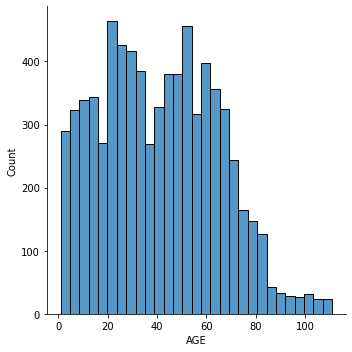

In [ ]:
# patients age distribution
sns.displot(patients["AGE"])
#sns.displot(imm["AGE"])
#sns.displot(nonimm["AGE"])

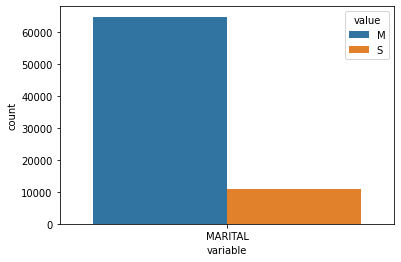

In [ ]:
# patients marital
#sns.countplot(x="variable", hue= "value", data=pd.melt(patients[["MARITAL"]]))
#sns.countplot(x="variable", hue= "value", data=pd.melt(imm[["MARITAL"]]))
sns.countplot(x="variable", hue= "value", data=pd.melt(nonimm[["MARITAL"]]))


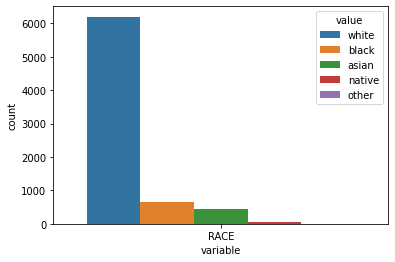

In [ ]:
# patients race
sns.countplot(x="variable", hue= "value", data=pd.melt(patients[["RACE"]]))

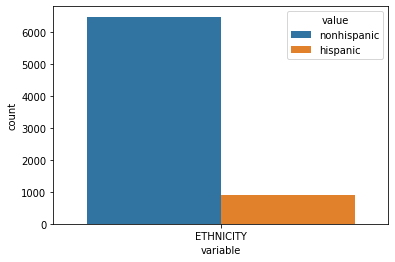

In [ ]:
# patients ethnicity
sns.countplot(x="variable", hue= "value", data=pd.melt(patients[["ETHNICITY"]]))

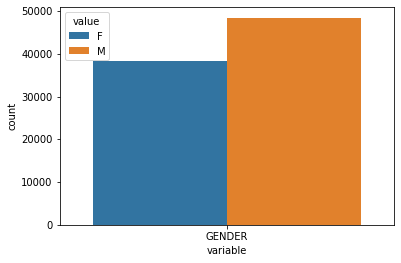

In [ ]:
# patients gender
sns.countplot(x="variable", hue= "value", data=pd.melt(nonimm[["GENDER"]]))

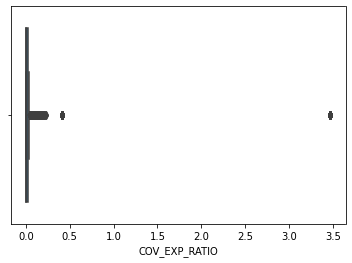

In [ ]:
# patients COV_EXP_RATIO - REMOVE OUTLIERS
sns.boxplot(x=patients["COV_EXP_RATIO"])

In [ ]:
patients = patients[patients["COV_EXP_RATIO"]<=1]

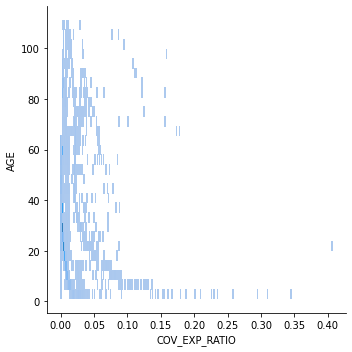

In [ ]:
# COV_EXP_RATIO / age
sns.displot(x=patients["COV_EXP_RATIO"], y=patients["AGE"])

In [ ]:
# COV_EXP_RATIO / marital
sns.displot(x=patients.dropna()["COV_EXP_RATIO"], y=patients.dropna()["MARITAL"])

In [ ]:
# COV_EXP_RATIO / age
sns.displot(x=patients["COV_EXP_RATIO"], y=patients["RACE"])

In [ ]:
# COV_EXP_RATIO / age
sns.displot(x=patients["COV_EXP_RATIO"], y=patients["ETHNICITY"])

In [ ]:
# COV_EXP_RATIO / age
sns.displot(x=patients["COV_EXP_RATIO"], y=patients["GENDER"])

In [ ]:
# convert categorical variable to numerical by replacing
patients.GENDER.replace(['M', 'F'], [0, 1], inplace=True)
patients.MARITAL.replace(['M', 'S'], [0, 1], inplace=True)
patients.RACE.replace(["white", "black", "asian", "native", "other"], [1, 2, 3, 4, 5], inplace=True)
patients.ETHNICITY.replace(["nonhispanic", "hispanic"], [0, 1], inplace=True)

In [ ]:
# Generating the correlating matrix
corr = patients.corr()
plt.figure(figsize=(7, 5))
# Generating the correlation heat-map

sns.heatmap(corr, annot=False)

In [ ]:
from sklearn.preprocessing import StandardScaler


features = ['RACE', 'ETHNICITY', 'GENDER', 'AGE']
# # Separating out the features
x = patients.loc[:, features].values
# # Separating out the target
y = np.round(patients.loc[:,['COV_EXP_RATIO']].values, 1)
# # Standardizing the features
x = StandardScaler().fit_transform(x)

# check normalization
x.shape, np.mean(x), np.std(x)

In [ ]:
# patients RACE after normalization
sns.countplot(x="variable", hue= "value", data=pd.melt(pd.DataFrame(x)[[0]]))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, patients[['COV_EXP_RATIO']].round(1)], axis = 1)
finalDf.head()

In [ ]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
finalDf['COV_EXP_RATIO'].unique()

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['RACE', 'ETHNICITY','GENDER', 'AGE']
targets = [0, 0.1, 0.2, 0.3, 0.4]
colors = ['r', 'g', 'b', 'c', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['COV_EXP_RATIO'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
# Descriptive statistics encounters
encounters.info()


In [ ]:
# distribution ENCOUNTERCLASS
sns.countplot(x="variable", hue= "value", data=pd.melt(encounters.groupby('Id').agg(np.unique)[['ENCOUNTERCLASS']]))


In [ ]:
# distribution DATASET_ORIGIN
sns.countplot(x="variable", hue= "value", data=pd.melt(encounters.groupby('Id').agg(np.unique)[['DATASET_ORIGIN']]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)

In [ ]:
# distribution PAYER_ID
sns.countplot(x="variable", hue= "value", data=pd.melt(encounters.groupby('Id').agg(np.unique)[['PAYER_Id']]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)

# FORSCHUNGSFRAGEN


## #1

In [ ]:
#1. Die Anzahl der Impfungen von Patienten korreliert negativ mit der Anzahl von notfallmäßigen Vorstellungen in einem Krankenhaus
# Entwurf Tabelle q1 (meint question1) mit Spalten: Patienten_Id, Anzahl_Impfungen, Anzahl Vorstellungen (mehrere Spalten nach ENCOUNTERCLASS)
# Umsetzung als SQL-Abfrage der Forschungsdatenbank:
q1 = pd.read_sql_query("""
SELECT count_pat_immunizations.patient_id, 
       count_pat_immunizations.immunizations, 
       Max(CASE 
             WHEN encounterclass = 'wellness' THEN pivot.count 
             ELSE 0 
           END) AS wellness, 
       Max(CASE 
             WHEN encounterclass = 'emergency' THEN pivot.count 
             ELSE 0 
           END) AS emergency, 
       Max(CASE 
             WHEN encounterclass = 'ambulatory' THEN pivot.count 
             ELSE 0 
           END) AS ambulatory, 
       Max(CASE 
             WHEN encounterclass = 'inpatient' THEN pivot.count 
             ELSE 0 
           END) AS inpatient, 
       Max(CASE 
             WHEN encounterclass = 'outpatient' THEN pivot.count 
             ELSE 0 
           END) AS outpatient, 
       Max(CASE 
             WHEN encounterclass = 'urgentcare' THEN pivot.count 
             ELSE 0 
           END) AS urgentcare 
FROM   (SELECT patient_id, 
               Count(DISTINCT id 
                              ||dataset_origin 
                              ||immunization_date 
                              ||immunization_code) AS immunizations 
        FROM   encounters 
        GROUP  BY patient_id) AS count_pat_immunizations, 
       (SELECT patient_id, 
               encounterclass, 
               Count(DISTINCT id 
                              ||dataset_origin) AS count 
        FROM   encounters 
        GROUP  BY patient_id, 
                  encounterclass) AS pivot 
WHERE  count_pat_immunizations.patient_id = pivot.patient_id 
GROUP  BY count_pat_immunizations.patient_id, 
          count_pat_immunizations.immunizations 
"""
, conn_new)

# Generating the correlating matrix
corr = q1.corr()
plt.figure(figsize=(7, 5))
# Generating the correlation heat-map
sns.heatmap(corr, annot=False)

In [ ]:
#plot immunizations->emergency
q1.plot.scatter(x=1, y=3, color='DarkGreen')

In [ ]:
# normalize data
# # Separating out feature
x = q1.loc[:, ['immunizations']].values
# # Separating out the target
y = q1['emergency'].values
# # Standardizing the features
x = StandardScaler().fit_transform(x)

# check normalization
x.shape, np.mean(x), np.std(x)

In [ ]:
# split data to testing and training dataset
from sklearn.model_selection import  train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# import regression model
from sklearn.linear_model import LinearRegression
# create an object
linreg = LinearRegression()
# train the model
linreg.fit(x, y)
# The coefficient
print('Coefficient: \n', linreg.coef_)

In [ ]:
# Making prediction using testing set
test_pred = linreg.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score
# the mean squared error
print("Mean squared error: %2f" % mean_squared_error(y_test, test_pred))
print("Coefficient of determination: %2f" % r2_score(y_test, test_pred))

# Plot outputs
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, test_pred, color='blue', linewidth=3)

#plt.xticks(())

plt.show()

In [ ]:
# Try linear regression w/ all encounterclasses as target
y = q1.loc[:, ['wellness', 'emergency', 'ambulatory', 'inpatient', 'outpatient', 'urgentcare']].values

# split data to testing and training dataset

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# train the model
linreg.fit(x, y)
# The coefficient
print('Coefficient: \n', linreg.coef_)

In [ ]:
# Making prediction using testing set
test_pred = linreg.predict(x_test)

# the mean squared error
print("Mean squared error: %2f" % mean_squared_error(y_test, test_pred))
print("Coefficient of determination: %2f" % r2_score(y_test, test_pred))

# Plot outputs
classvalue = 0
while classvalue < len(y_test[0]):
  sns.regplot(x=x_test, y=y_test[:,classvalue])
  classvalue +=1

In [ ]:
# Perform linear regression analysis for 'wellness'
#x stays the same (immunizations)
y = q1['wellness'].values
# split data to testing and training dataset

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# train the model
linreg.fit(x, y)
# The coefficient
print('Coefficient: \n', linreg.coef_)

# Making prediction using testing set
test_pred = linreg.predict(x_test)

# the mean squared error
print("Mean squared error: %2f" % mean_squared_error(y_test, test_pred))
print("Coefficient of determination: %2f" % r2_score(y_test, test_pred))

In [ ]:
# bei welchen Aufenthalten erfolgen Impfungen zumeist?
#sql_query
q1b = pd.read_sql_query("""
SELECT
Id,
ENCOUNTERCLASS
FROM
encounters
GROUP BY Id, DATASET_ORIGIN
HAVING COUNT(immunization_CODE)>0
""", conn_new)
# countplot
sns.countplot(x="variable", hue= "value", data=pd.melt(q1b[['ENCOUNTERCLASS']]))
plt.yscale('log')


## --> Die Anzahl der Impfungen von Patienten korreliert minimal negativ mit der Anzahl von notfallmäßigen Vorstellungen in einem Krankenhaus. Ein auf dieser Annahme basierendes Regressionsmodell zeigt eine Genauigkeit von 0,58%.

## --> Es konnte eine positive Korrelation der Anzahl der Impfungen mit der Anzahl der 'wellness' Aufenthalte gezeigt werden, ein auf dieser Annahme basierendes Regressionsmodell zeigt eine Genauigkeit von 58,47%.

## --> Diese Beobachtung ergibt Sinn, da Impfungen zumeist während wellness Aufenthalten erfolgen.